In [1]:
import os
import pickle
import sys

import geotiff as gt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapefile
from scipy.spatial import cKDTree
from shapely.geometry import LineString

sys.path.append("../")

In [2]:
from plot_functions import add_poly, plot_shp_line, plot_shp_poly
from utils import from_pickle, to_pickle

In [3]:
os.makedirs("outputs/", exist_ok=True)

In [4]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True

In [5]:
GEOPHYS_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/Geophys/"
GEOCHEM_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/Geochem/"
GEO_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/BC_digital_geology_shp/"
DEM_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/DEM/"

In [6]:
strat_colors = pd.read_csv(
    GEO_DIR + "BC_bedrock_strat_unit_colour_hex.csv", delimiter=";"
)
strat_colors = dict(zip(strat_colors["strat_unit"], strat_colors["color_hex"]))
strat_colors["Qal"] = "#d2aa87"

# Shapefiles

In [7]:
bedrock = shapefile.Reader(GEO_DIR + "BC_bedrock_ll83_merged.shp")
faults = shapefile.Reader(GEO_DIR + "BC_faults_ll83_clipped.shp")
cover = shapefile.Reader(GEO_DIR + "BC_quaternary_ll83_merged.shp")
bbox = shapefile.Reader("./shapefile/bbox_polygon.shp")

In [8]:
alpha_shape = from_pickle("./outputs/boundary_poly.pkl")

In [9]:
bedrock.record(0)

Record #0: [255, 40329, '539ffa04', 437261768.0, 'KSTCss', 'Mesozoic', 'Cretaceous', 'Lower to Upper Cretaceous', 'Sustut Group - Tango Creek Formation', 'Sustut Group', 'Tango Creek Formation', '', 'sedimentary rocks', 'sandstone', '', '', 'Lower Cretaceous', 'Upper Cretaceous', 'Intermontane', 'Overlap', 'Sustut Basin', 'Cretaceous', 'Bowser and Sustut Basins', 'https://doi.org/10.4095/224310', 'Evenchick et al., 2007, Toodoggone River, GSC, OF5570', 'Evenchick et al., 2009, Bowser and Sustut Basins', '2019-12-19', 'British Columbia Geological Survey']

In [10]:
lith = []
rock_class = []
age = []
for shape in bedrock.iterRecords():
    lith.append(shape[4])
    rock_class.append(shape[12])
    age.append(shape[6])
lith_set = set(lith)
rock_set = set(rock_class)
age_set = set(age)

In [11]:
sets = {"lith": lith_set, "age": age_set, "class": rock_set}

## Strat Unit

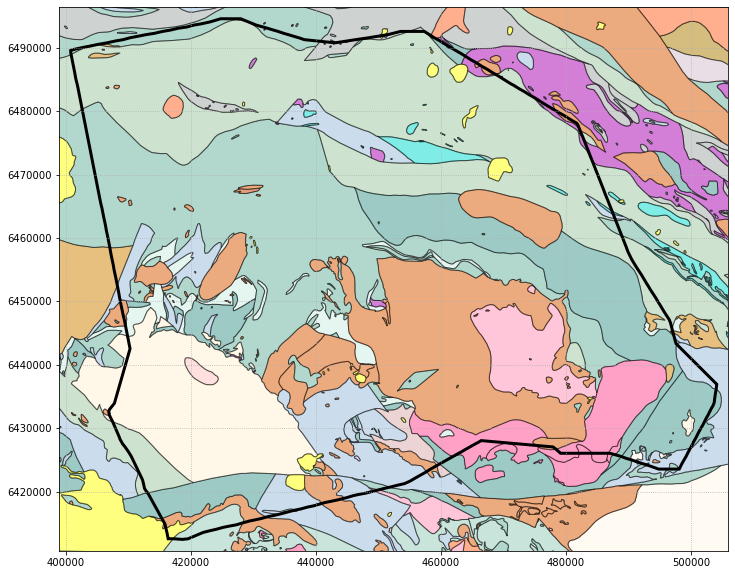

In [12]:
# strat unit = 4
fig, ax = plot_shp_poly(
    bedrock,
    4,
    strat_colors,
    {"edgecolor": "k", "alpha": 0.5},
    bbox.bbox,
    (12, 10),
)
add_poly(ax, alpha_shape, {"fill": False, "lw": 3})

## Rock Class

In [13]:
# choose random colours for rock class from master list
np.random.seed(11)
class_colors = {}
for rock in rock_set:
    class_colors[rock] = np.random.choice(list(strat_colors.values()))
class_colors

{'volcanic rocks': '#3c968c',
 'ultramafic rocks': '#db5700',
 'mafic volcanic rocks': '#2ba600',
 'sedimentary rocks': '#ff4591',
 'intrusive rocks': '#9fa6a3',
 'metamorphic rocks': '#ebfac5',
 'volcanic and sedimentary rocks': '#e9967a'}

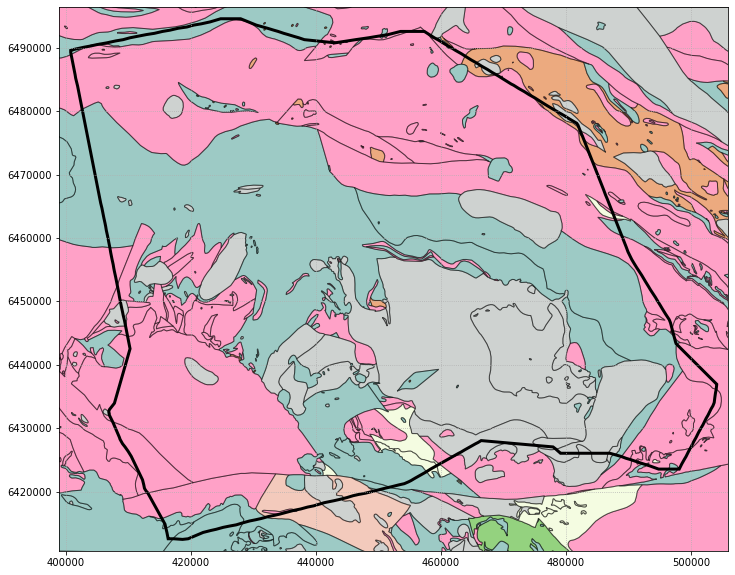

In [14]:
# rock class = 12
fig, ax = plot_shp_poly(
    bedrock,
    12,
    class_colors,
    {"edgecolor": "k", "alpha": 0.5},
    bbox.bbox,
    (12, 10),
)
add_poly(ax, alpha_shape, {"fill": False, "lw": 3})

## Rock Age

In [15]:
# choose random colours for rock age from master list
np.random.seed(34)
age_colors = {}
for age in age_set:
    age_colors[age] = np.random.choice(list(strat_colors.values()))
age_colors

{'Neogene to Quaternary': '#ffc2bf',
 'Jurassic': '#64f0b4',
 'Permian': '#ff4591',
 'Cambrian': '#9fa6a3',
 'Quaternary': '#d487b5',
 'Triassic to Jurassic': '#80b5d5',
 'Carboniferous to Triassic': '#9fa6a3',
 'Mississippian': '#ff8a63',
 'Carboniferous to Permian': '#ff611f',
 'Triassic to Neogene': '#ff611f',
 'Permian to Triassic': '#cbbddc',
 'Paleogene': '#50b47d',
 'Triassic': '#ff9c94',
 'Cretaceous': '#ff8cb5',
 'Cambrian to Ordovician': '#b3df7f',
 'Devonian to Permian': '#80b5d5',
 'Paleozoic': '#95cbb8'}

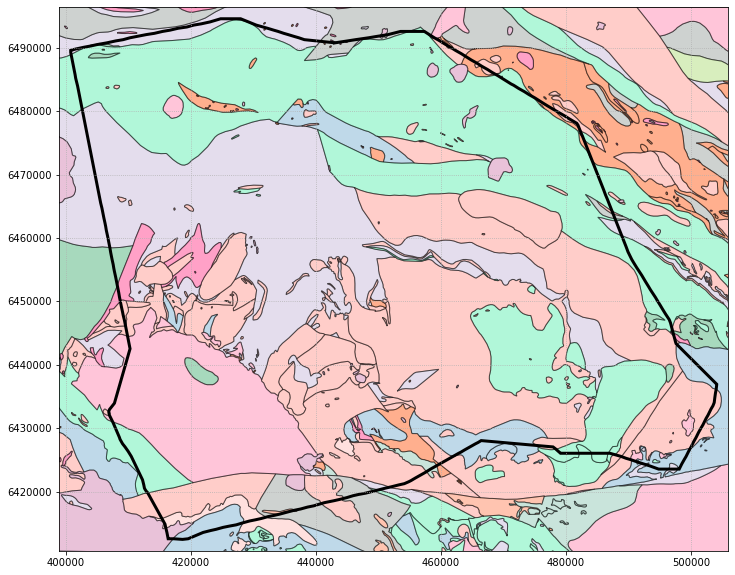

In [16]:
# rock age = 6
fig, ax = plot_shp_poly(
    bedrock,
    6,
    age_colors,
    {"edgecolor": "k", "alpha": 0.5},
    bbox.bbox,
    (12, 10),
)
add_poly(ax, alpha_shape, {"fill": False, "lw": 3})

## Quaternary Cover

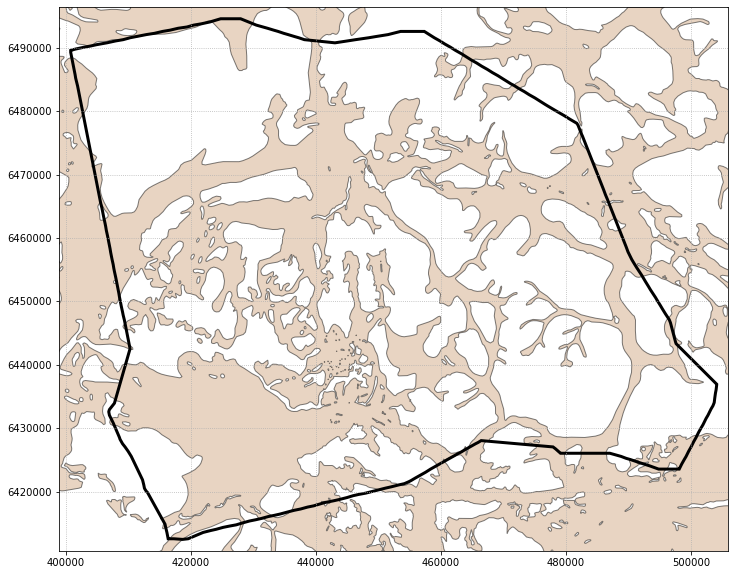

In [17]:
fig, ax = plot_shp_poly(
    cover,
    2,
    strat_colors,
    {"edgecolor": "k", "alpha": 0.5},
    bbox.bbox,
    (12, 10),
)
add_poly(ax, alpha_shape, {"fill": False, "lw": 3})

## Faults

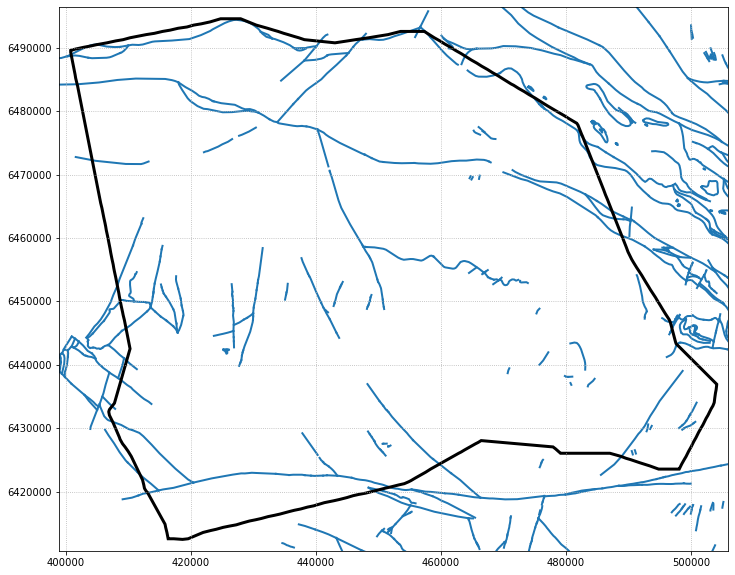

In [18]:
fig, ax = plot_shp_line(
    faults,
    {"c": "C0", "lw": 2, "alpha": 1.0, "zorder": -1},
    bbox.bbox,
    (12, 10),
)
add_poly(ax, alpha_shape, {"fill": False, "lw": 3, "alpha": 1.0})

In [19]:
shp_lims = (ax.get_ylim(), ax.get_xlim())

# GeoTiff

In [20]:
rasters = {
    "topo": np.array(
        gt.GeoTiff(DEM_DIR + "DEM_clipped_25m.tif", as_crs=26909).read()
    ),
    "lith": np.array(
        gt.GeoTiff(
            GEO_DIR + "BC_bedrock_ll83_merged_raster_25m.tif", as_crs=26909
        ).read()
    ),
    "class": np.array(
        gt.GeoTiff(
            GEO_DIR + "BC_rock_class_ll83_merged_raster_25m.tif", as_crs=26909
        ).read()
    ),
    "age": np.array(
        gt.GeoTiff(
            GEO_DIR + "BC_strat_age_ll83_merged_raster_25m.tif", as_crs=26909
        ).read()
    ),
    "cover": np.array(
        gt.GeoTiff(
            GEO_DIR + "BC_quaternary_ll83_merged_raster_25m.tif", as_crs=26909
        ).read()
    ),
    "fault": np.array(
        gt.GeoTiff(
            GEO_DIR + "BC_faults_ll83_merged_raster_25m.tif", as_crs=26909
        ).read()
    ),
}
nx = rasters["lith"].shape[1]
ny = rasters["lith"].shape[0]
print(nx, ny)

4287 3433


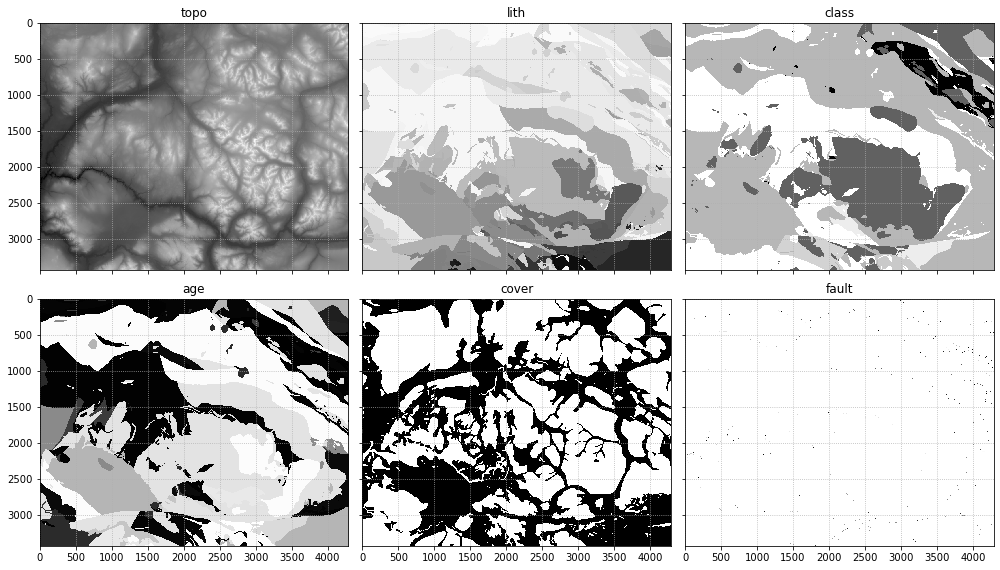

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex="all", sharey="all")
axes = axes.flatten()
for i, (key, var) in enumerate(rasters.items()):
    axes[i].imshow(var)
    axes[i].set_title(key)
fig.tight_layout()

In [22]:
# check rasterized categories match shapefile data
for key, value in sets.items():
    check = len(np.unique(rasters[key][:, :, 0])) == len(value)
    print(key + " raster categories match shapefile:", check)

lith raster categories match shapefile: True
age raster categories match shapefile: True
class raster categories match shapefile: True


In [23]:
# # export grid origin and shape for geochem interpolation   
to_pickle("outputs/grid_origin.pkl", [rasters["lith"].shape[0:2], shp_lims])

In [24]:
rasters["lith"].shape[0:2], shp_lims

((3433, 4287),
 ((6410638.793103448, 6496463.793103448),
  (398838.7931034483, 506013.7931034483)))

# Distance to Faults

In [25]:
lines_nested = [shape.points for shape in faults.shapes()]

In [26]:
def densify_LineString(line, factor):
    """densify points in line by npts * factor"""
    n = len(line)
    ls = LineString(line)
    new_points = [
        ls.interpolate(i / (n * factor - 1), normalized=True)
        for i in range(n * factor)
    ]
    return [(point.x, point.y) for point in new_points]

In [27]:
# densify by a factor of 3 to avoid artifacts in distance to NN map
lines_dense = [
    densify_LineString(lines_nested[i], factor=3)
    for i in range(len(lines_nested))
]

In [28]:
# flatten the nested list
lines = np.array([item for sublist in lines_dense for item in sublist])

In [29]:
x_arr, y_arr = (
    gt.GeoTiff(GEO_DIR + "BC_faults_ll83_merged_raster_25m.tif", as_crs=26909)
).get_coord_arrays()

grid_locs = np.concatenate([x_arr.reshape(-1, 1), y_arr.reshape(-1, 1)], axis=1)

26909


In [30]:
tree = cKDTree(lines)
dist = np.zeros((len(grid_locs), 1))

for idx in range(len(grid_locs)):
    ndist, nind = tree.query(grid_locs[idx, :], k=1)
    dist[idx] = ndist

In [31]:
dist = dist.reshape(ny, nx, 1)

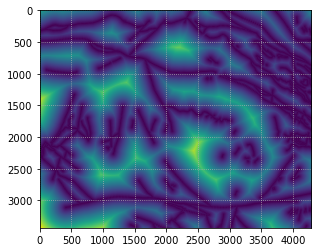

In [32]:
plt.imshow(dist[:, :, 0])

# Image Processing
- Redcuce duplicated channels from the GeoTiffs
- Code categories as binary channels (ny, nx, nclass)
- Cover and faults are already binary
- Normalize topo grayscale values $\in [0,1]$

In [48]:
geo_channels = {}

In [34]:
rasters["topo"] = (
    rasters["topo"][:, :, 0].reshape(ny, nx, 1) / 255
)  # scales [0,1]
rasters["lith"] = rasters["lith"][:, :, 0].reshape(ny, nx, 1)
rasters["class"] = rasters["class"][:, :, 0].reshape(ny, nx, 1)
rasters["age"] = rasters["age"][:, :, 0].reshape(ny, nx, 1)
rasters["cover"] = rasters["cover"][:, :, -1].reshape(ny, nx, 1)
rasters["fault"] = dist / np.max(dist) # scales [0,1]

In [49]:
geo_channels["topo"] = np.copy(rasters["topo"])
geo_channels["cover"] = np.copy(rasters["cover"])
geo_channels["fault"] = np.copy(rasters["fault"])

topo


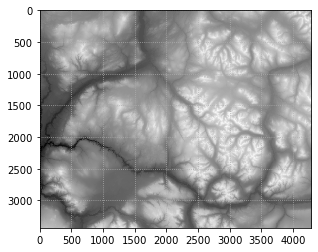

lith


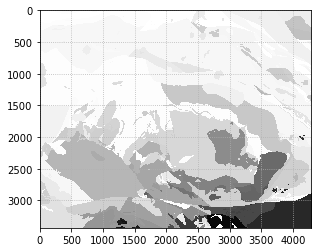

class


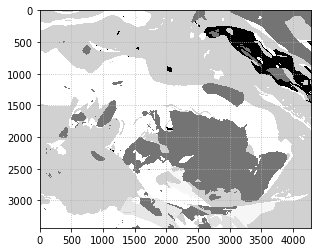

age


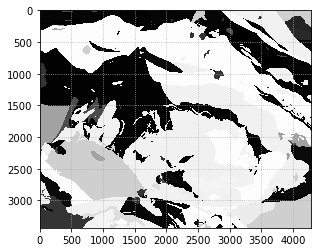

cover


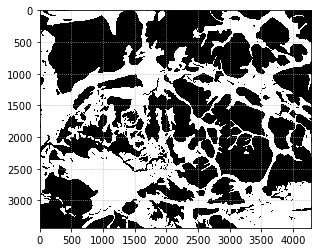

fault


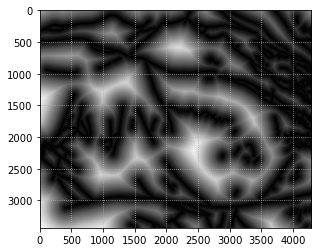

In [50]:
for key, value in rasters.items():
    print(key)
    for i in range(value.shape[-1]):
        plt.imshow(value[:, :, i], cmap="Greys_r")
        plt.show()

## Strat Unit

In [51]:
pos_idx = (404, 580)

In [52]:
units = np.unique(rasters["lith"].ravel())
units

array([  5,   9,  13,  17,  21,  26,  30,  34,  38,  43,  47,  51,  55,
        60,  64,  68,  72,  77,  81,  85,  89,  94,  98, 102, 106, 111,
       115, 119, 123, 128, 132, 136, 140, 144, 149, 153, 157, 161, 166,
       170, 174, 178, 183, 187, 191, 195, 200, 204, 208, 212, 217, 221,
       225, 229, 234, 238, 242, 246, 250], dtype=uint8)

In [53]:
len(units)

59

In [54]:
# geo_channels["lith"] = np.zeros((ny, nx, len(units)))
# for ic, unit in enumerate(units):
#     bin_arr = rasters["lith"][:, :, 0] == unit
#     geo_channels["lith"][:, :, ic] = bin_arr
#     plt.imshow(bin_arr)
#     plt.scatter(pos_idx[0], pos_idx[1], c="r", s=10)
#     plt.show()

## Rock Class

In [55]:
classes = np.unique(rasters["class"].ravel())
classes

array([  0,  97, 183, 201, 211, 237, 255], dtype=uint8)

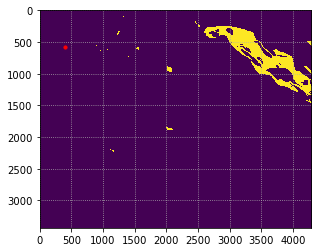

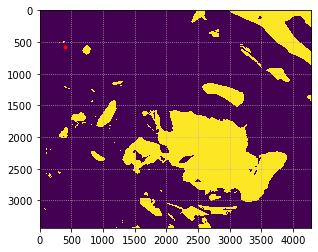

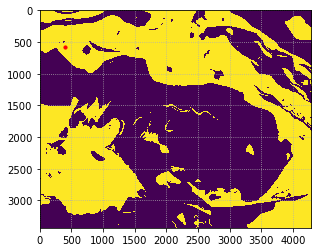

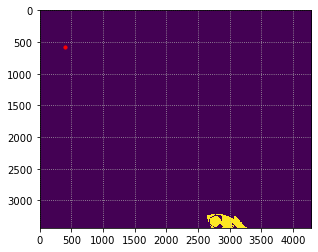

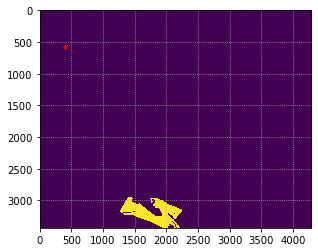

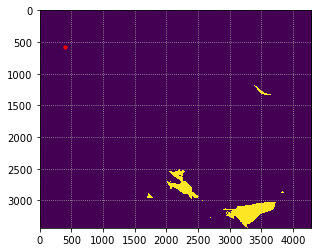

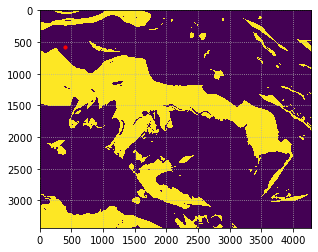

In [56]:
geo_channels["class"] = np.zeros((ny, nx, len(classes)))
for ic, rclass in enumerate(classes):
    bin_arr = rasters["class"][:, :, 0] == rclass
    geo_channels["class"][:, :, ic] = bin_arr
    plt.imshow(bin_arr)
    plt.scatter(pos_idx[0], pos_idx[1], c="r", s=10)
    plt.show()

## Rock Age

In [57]:
ages = np.unique(rasters["age"].ravel())
ages

array([  0,   2,   5,  10,  31,  35,  43,  60, 138, 181, 197, 203, 218,
       227, 233, 252, 255], dtype=uint8)

In [58]:
# geo_channels["age"] = np.zeros((ny, nx, len(ages)))
# for ic, age in enumerate(ages):
#     bin_arr = rasters["age"][:, :, 0] == age
#     geo_channels["age"][:, :, ic] = bin_arr
#     plt.imshow(bin_arr)
#     plt.scatter(pos_idx[0], pos_idx[1], c="r", s=10)
#     plt.show()

# Final Layers

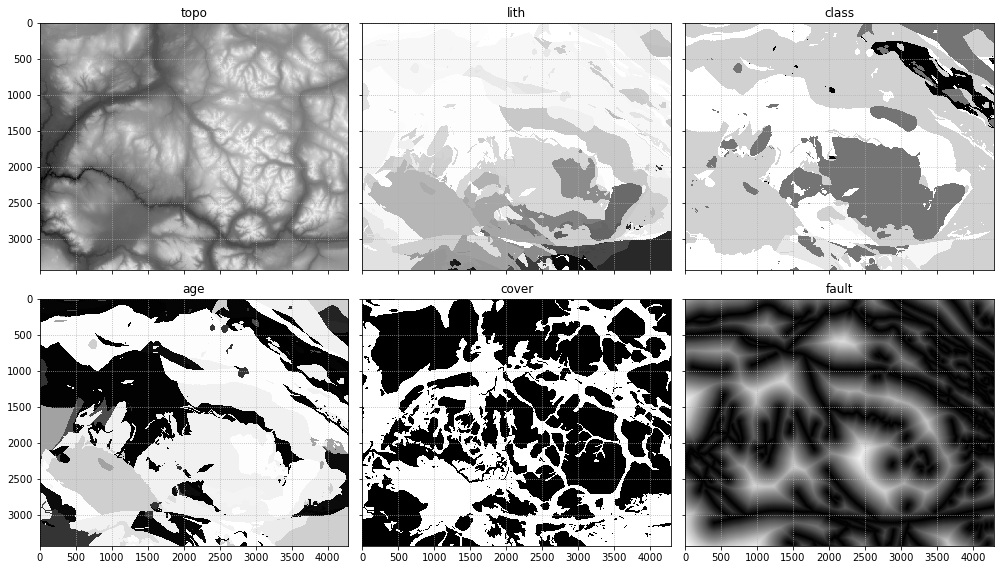

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex="all", sharey="all")
axes = axes.flatten()
for i, (key, var) in enumerate(rasters.items()):
    axes[i].imshow(var[...,0], cmap="Greys_r")
    axes[i].set_title(key)
fig.tight_layout()

In [60]:
# tensor shapes
for key, value in geo_channels.items():
    print(key + " shape:", value.shape)

topo shape: (3433, 4287, 1)
cover shape: (3433, 4287, 1)
fault shape: (3433, 4287, 1)
class shape: (3433, 4287, 7)


In [61]:
to_pickle("./outputs/geo_channels.pkl", geo_channels)
to_pickle("./outputs/geo_rasters.pkl", rasters)